In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "openai.com"
full_url = "https://openai.com/"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://openai.com/
https://openai.com/research/overview
https://openai.com/careers/model-teacher-contract
https://openai.com/careers/model-teacher-contract#content
https://openai.com/research/solving-rubiks-cube
https://openai.com/research?authors=nikolas-tezak
https://openai.com/research?topics=computer-vision


KeyboardInterrupt: 

In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie


In [3]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))



In [4]:
# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()


/tmp/ipykernel_478/2966875972.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,research?authors=peter zhokhov,research?authors=peter zhokhov. Research inde...
1,blog introducing superalignment#content,blog introducing superalignment#content. Intr...
2,careers research software engineer data quality,careers research software engineer data qualit...
3,blog musenet,blog musenet. MuseNet CloseSearch Submit S...
4,blog using gpt 4 for content moderation#Andrea...,blog using gpt 4 for content moderation#Andrea...


<Axes: >

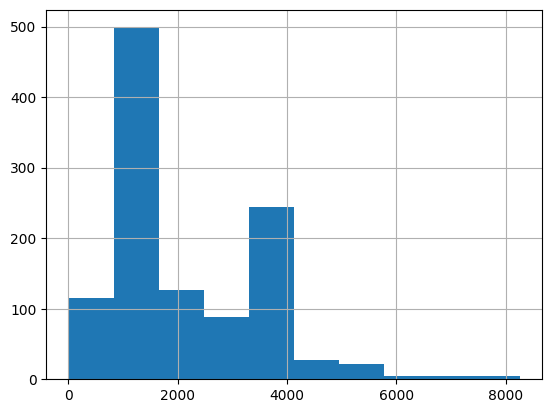

In [5]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [7]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )


<Axes: >

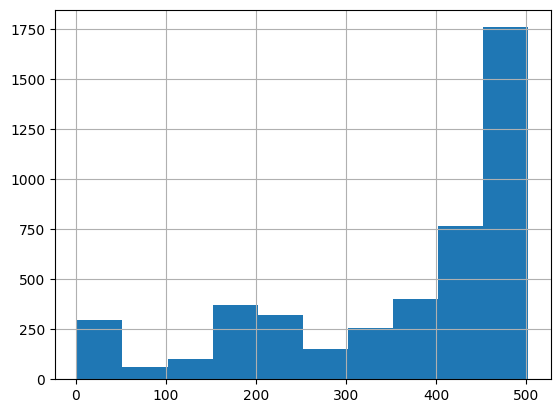

In [8]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [14]:
df.text

0                         research?authors=peter zhokhov.
1       BartlettÂ  (1)Mohammad BavarianÂ  (2)Alexandre...
2       EfrosÂ  (1)Tyna EloundouÂ  (3)Ãlfar Erlingsso...
3       RobinsonÂ  (1)Nick RyderÂ  (2)Ruslan Salakhutd...
4       blog introducing superalignment#content.  Intr...
                              ...                        
4485    Filter and sort Filter selectionsTopicsLanguag...
4486    research the international 2018 results#rules ...
4487    Winning is good, but losing shows the amazing ...
4488    During a normal Dota game, heroes at low healt...
4489    research hierarchical text conditional image g...
Name: text, Length: 4490, dtype: object

In [45]:
from openai import OpenAI
client = OpenAI()

#def get_embedding(text, model="text-embedding-ada-002"):
#   text = text.replace("\n", " ")
#   return client.embeddings.create(input = [text], model=model)['data'][0]['embedding']

def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model=model).data[0].embedding

df['embeddings'] = df.text.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

# df['embeddings'] = df.text.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

# df['embeddings'] = df.text.apply(lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,research?authors=peter zhokhov.,10,"[0.006480093114078045, -0.018002212047576904, ..."
1,BartlettÂ (1)Mohammad BavarianÂ (2)Alexandre...,426,"[0.0006464956677518785, -0.0005293454159982502..."
2,EfrosÂ (1)Tyna EloundouÂ (3)Ãlfar Erlingsso...,195,"[0.002814270555973053, -0.003521270351484418, ..."
3,RobinsonÂ (1)Nick RyderÂ (2)Ruslan Salakhutd...,215,"[0.0025212429463863373, -0.0010925385868176818..."
4,blog introducing superalignment#content. Intr...,480,"[0.013897379860281944, -0.005521391052752733, ..."


In [49]:
text = df.text[0]
text

'research?authors=peter zhokhov.'

In [50]:
model="text-embedding-ada-002"
# rl1 = client.embeddings.create(input = [text], model=model).data[0].embedding
rl1 = client.embeddings.create(input = [text], model=model)

In [58]:
rl1.data[0].embedding

[0.006480093114078045,
 -0.018002212047576904,
 -0.00929645448923111,
 -0.024359242990612984,
 0.010013730265200138,
 0.04213642701506615,
 -0.007897064089775085,
 -0.018058467656373978,
 -0.03217895328998566,
 -0.026876740157604218,
 0.006733248941600323,
 0.019661789759993553,
 -0.01289689727127552,
 0.026637647300958633,
 -0.014415833167731762,
 0.01960553415119648,
 0.014725246466696262,
 -0.003516057040542364,
 0.0019267991883680224,
 -0.01565348543226719,
 -0.026609519496560097,
 0.006902019958943129,
 -0.009373808279633522,
 -0.009176908992230892,
 -0.015892578288912773,
 0.029000436887145042,
 0.026679839938879013,
 -0.02215115912258625,
 0.0038571145851165056,
 -0.0004263219016138464,
 0.009746509604156017,
 -0.007278237957507372,
 -0.014950274489820004,
 -0.02531561069190502,
 -0.020997891202569008,
 -0.0056643676944077015,
 0.003132806858047843,
 -0.019535211846232414,
 0.023613838478922844,
 -0.0040856581181287766,
 0.006575026549398899,
 0.00144773640204221,
 0.00486270664

In [60]:
from openai.embeddings_utils import cosine_similarity

ModuleNotFoundError: No module named 'openai.embeddings_utils'

In [59]:
import pandas as pd
import numpy as np
from ast import literal_eval
# from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,research?authors=peter zhokhov.,10,"[0.006480093114078045, -0.018002212047576904, ..."
1,BartlettÂ (1)Mohammad BavarianÂ (2)Alexandre...,426,"[0.0006464956677518785, -0.0005293454159982502..."
2,EfrosÂ (1)Tyna EloundouÂ (3)Ãlfar Erlingsso...,195,"[0.002814270555973053, -0.003521270351484418, ..."
3,RobinsonÂ (1)Nick RyderÂ (2)Ruslan Salakhutd...,215,"[0.0025212429463863373, -0.0010925385868176818..."
4,blog introducing superalignment#content. Intr...,480,"[0.013897379860281944, -0.005521391052752733, ..."


In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.embeddings.create(input=question, model='text-embedding-ada-002').data[0].embedding

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [ ]:
answer_question(df, question="What day is it?", debug=False)

In [ ]:
answer_question(df, question="What is our newest embeddings model?")